In [1]:
import torchvision.transforms as transforms
import torchvision
import torch

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

trnBatchSize = 79

#train_data_path = 'relative path of training data set'
train_data_path = './horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size = trnBatchSize, shuffle=True, num_workers=1)  


validation_data_path = './horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=True, num_workers=1) 



In [2]:
import torch.nn as nn
import torch.nn.functional as F
import math

class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 50
        _num2           = 50
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.ReLU(True))
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        
        self._initialize_weight()        
        
    def _initialize_weight(self):

        for m in self.modules():
            

            if type(m) == nn.Linear:
            
                n = m.in_features
                m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))
                if m.bias is not None:

                    m.bias.data.zero_()
                    

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [3]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform

from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------
num_classes = 2

# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------


model = Linear(num_classes=num_classes)

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 0

if bCuda:
 
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

optimizer   = optim.SGD(model.parameters(), lr = 0.001)
objective   = nn.CrossEntropyLoss()

# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():

    # print('train the model at given epoch')

    loss_train          = []
    accuracy_train      = []


    model.train()
    for idx_batch, (data, target) in enumerate(trainloader):
        
        if len(data) == trnBatchSize:
            correct = 0
            if bCuda:

                data, target    = data.cuda(), target.cuda()

            data, target    = Variable(data), Variable(target)

            optimizer.zero_grad()

            output  = model(data)
            loss    = objective(output, target)
            loss.backward()
            optimizer.step()

            loss_train_batch    = loss.item()
            loss_train.append(loss_train_batch)

            pred        = output.data.max(1)[1]
            correct     = pred.eq(target.data.view_as(pred)).cpu().sum()
            accuracy_train.append(100. * float(correct) / len(data))


    loss_train_mean     = np.mean(loss_train)
    loss_train_std      = np.std(loss_train)
    accuracy_train_mean     = np.mean(accuracy_train)
    accuracy_train_std      = np.std(accuracy_train)
    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 
            'accuracy_train_mean' : accuracy_train_mean, 'accuracy_train_std' : accuracy_train_std}

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(valloader):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test / len(valloader.dataset)
    accuracy_test   = 100. * float(correct) / len(valloader.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}



In [4]:
# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------
from tqdm import tqdm


loss_train_mean =[]
loss_train_std = []
accuracy_train_mean = []
accuracy_train_std = []

accuracy_test = []
loss_test = []


totalEpoch = 1000
loop = tqdm(total = totalEpoch, position = 0, leave = False)

for e in range(totalEpoch):
    loop.set_description("Processing".format(e))
    loop.update(1)
    result_train    = train()
    result_test     = test()

    loss_train_mean.append(result_train['loss_train_mean'])
    accuracy_train_mean.append(result_train['accuracy_train_mean'])
    
    loss_train_std.append(result_train['loss_train_std'])
    accuracy_train_std.append(result_train['accuracy_train_std'])
    
    loss_test.append(result_test['loss_test'])
    accuracy_test.append(result_test['accuracy_test'])
    
    print("[epoch %5d] loss: (trn) %.10f, (test) %.10f, accuracy: (trn) %.10f, (test) %.10f" 
         % (e, loss_train_mean[e], loss_test[e], accuracy_train_mean[e], accuracy_test[e]))


[epoch     0] loss: (trn) 0.6927405687, (test) 0.6983910720, accuracy: (trn) 50.8276533593, (test) 45.7031250000
[epoch     1] loss: (trn) 0.6900389057, (test) 0.6961110076, accuracy: (trn) 54.2356377799, (test) 49.6093750000
[epoch     2] loss: (trn) 0.6882747182, (test) 0.6949459508, accuracy: (trn) 53.6514118793, (test) 49.6093750000
[epoch     3] loss: (trn) 0.6869799586, (test) 0.6934779948, accuracy: (trn) 53.8461538462, (test) 49.6093750000
[epoch     4] loss: (trn) 0.6857193800, (test) 0.6921464901, accuracy: (trn) 55.5014605648, (test) 50.0000000000
[epoch     5] loss: (trn) 0.6844935922, (test) 0.6913246776, accuracy: (trn) 55.3067185979, (test) 49.6093750000
[epoch     6] loss: (trn) 0.6829651961, (test) 0.6897527550, accuracy: (trn) 56.4751703992, (test) 50.0000000000
[epoch     7] loss: (trn) 0.6815602046, (test) 0.6878583615, accuracy: (trn) 57.8383641675, (test) 50.7812500000
[epoch     8] loss: (trn) 0.6800266000, (test) 0.6854439336, accuracy: (trn) 57.4488802337, (tes

[epoch    73] loss: (trn) 0.5659037232, (test) 0.4795391054, accuracy: (trn) 75.4625121714, (test) 86.7187500000
[epoch    74] loss: (trn) 0.5643267632, (test) 0.4773313449, accuracy: (trn) 75.0730282376, (test) 84.7656250000
[epoch    75] loss: (trn) 0.5620668439, (test) 0.4742760546, accuracy: (trn) 75.4625121714, (test) 84.7656250000
[epoch    76] loss: (trn) 0.5597911752, (test) 0.4718523198, accuracy: (trn) 75.4625121714, (test) 85.1562500000
[epoch    77] loss: (trn) 0.5576135424, (test) 0.4711909753, accuracy: (trn) 75.4625121714, (test) 85.5468750000
[epoch    78] loss: (trn) 0.5557927581, (test) 0.4625430398, accuracy: (trn) 76.0467380721, (test) 86.7187500000
[epoch    79] loss: (trn) 0.5542078385, (test) 0.4604730253, accuracy: (trn) 74.9756572541, (test) 85.5468750000
[epoch    80] loss: (trn) 0.5522748690, (test) 0.4578815482, accuracy: (trn) 75.6572541383, (test) 84.7656250000
[epoch    81] loss: (trn) 0.5497855636, (test) 0.4567235673, accuracy: (trn) 75.4625121714, (tes

[epoch   146] loss: (trn) 0.4444244366, (test) 0.3298086138, accuracy: (trn) 80.0389483934, (test) 86.7187500000
[epoch   147] loss: (trn) 0.4432095037, (test) 0.3218876606, accuracy: (trn) 80.1363193768, (test) 85.9375000000
[epoch   148] loss: (trn) 0.4412643268, (test) 0.3178759661, accuracy: (trn) 81.0126582278, (test) 86.7187500000
[epoch   149] loss: (trn) 0.4410170042, (test) 0.3210252724, accuracy: (trn) 80.2336903603, (test) 86.3281250000
[epoch   150] loss: (trn) 0.4397733166, (test) 0.3311245260, accuracy: (trn) 80.8179162610, (test) 86.3281250000
[epoch   151] loss: (trn) 0.4374742347, (test) 0.3257804799, accuracy: (trn) 80.6231742941, (test) 87.1093750000
[epoch   152] loss: (trn) 0.4356043866, (test) 0.3087869652, accuracy: (trn) 81.0126582278, (test) 86.7187500000
[epoch   153] loss: (trn) 0.4356209980, (test) 0.3177858811, accuracy: (trn) 80.7205452775, (test) 86.7187500000
[epoch   154] loss: (trn) 0.4355918650, (test) 0.3212151572, accuracy: (trn) 80.8179162610, (tes

[epoch   219] loss: (trn) 0.3611459067, (test) 0.3388331687, accuracy: (trn) 85.1022395326, (test) 82.8125000000
[epoch   220] loss: (trn) 0.3619256386, (test) 0.3084049862, accuracy: (trn) 85.1022395326, (test) 85.5468750000
[epoch   221] loss: (trn) 0.3598887324, (test) 0.2967545689, accuracy: (trn) 85.2969814995, (test) 87.1093750000
[epoch   222] loss: (trn) 0.3585518232, (test) 0.3010566541, accuracy: (trn) 85.4917234664, (test) 85.9375000000
[epoch   223] loss: (trn) 0.3577822263, (test) 0.3127467954, accuracy: (trn) 84.9074975657, (test) 85.1562500000
[epoch   224] loss: (trn) 0.3561857366, (test) 0.3131001894, accuracy: (trn) 85.4917234664, (test) 85.1562500000
[epoch   225] loss: (trn) 0.3553205476, (test) 0.3303151718, accuracy: (trn) 85.7838364167, (test) 84.3750000000
[epoch   226] loss: (trn) 0.3560276169, (test) 0.3113457408, accuracy: (trn) 85.1996105161, (test) 85.1562500000
[epoch   227] loss: (trn) 0.3531916050, (test) 0.2946145056, accuracy: (trn) 85.8812074002, (tes

[epoch   292] loss: (trn) 0.2912393843, (test) 0.3340982334, accuracy: (trn) 89.2891918208, (test) 83.5937500000
[epoch   293] loss: (trn) 0.2877948811, (test) 0.3500689137, accuracy: (trn) 90.0681596884, (test) 82.4218750000
[epoch   294] loss: (trn) 0.2868426797, (test) 0.3446613833, accuracy: (trn) 89.8734177215, (test) 82.8125000000
[epoch   295] loss: (trn) 0.2886464871, (test) 0.3083160355, accuracy: (trn) 89.4839337877, (test) 87.1093750000
[epoch   296] loss: (trn) 0.2852450644, (test) 0.3249782270, accuracy: (trn) 89.6786757546, (test) 84.7656250000
[epoch   297] loss: (trn) 0.2878117699, (test) 0.3574729744, accuracy: (trn) 89.2891918208, (test) 82.0312500000
[epoch   298] loss: (trn) 0.2842076352, (test) 0.3230447434, accuracy: (trn) 90.3602726388, (test) 84.7656250000
[epoch   299] loss: (trn) 0.2810773655, (test) 0.3029846266, accuracy: (trn) 90.3602726388, (test) 87.8906250000
[epoch   300] loss: (trn) 0.2827616070, (test) 0.3519302441, accuracy: (trn) 89.4839337877, (tes

[epoch   365] loss: (trn) 0.2288103539, (test) 0.3980478234, accuracy: (trn) 92.6971762415, (test) 80.8593750000
[epoch   366] loss: (trn) 0.2294174330, (test) 0.3558599943, accuracy: (trn) 93.1840311587, (test) 83.5937500000
[epoch   367] loss: (trn) 0.2278219232, (test) 0.4027450316, accuracy: (trn) 92.9892891918, (test) 80.8593750000
[epoch   368] loss: (trn) 0.2273950221, (test) 0.3893639303, accuracy: (trn) 92.9892891918, (test) 81.6406250000
[epoch   369] loss: (trn) 0.2262062190, (test) 0.4081857319, accuracy: (trn) 93.4761441091, (test) 80.8593750000
[epoch   370] loss: (trn) 0.2265367416, (test) 0.3877954164, accuracy: (trn) 93.1840311587, (test) 81.2500000000
[epoch   371] loss: (trn) 0.2255707097, (test) 0.4110367062, accuracy: (trn) 93.3787731256, (test) 80.8593750000
[epoch   372] loss: (trn) 0.2233028458, (test) 0.3991611184, accuracy: (trn) 93.5735150925, (test) 80.4687500000
[epoch   373] loss: (trn) 0.2227015071, (test) 0.4271185467, accuracy: (trn) 93.6708860759, (tes

[epoch   438] loss: (trn) 0.1788913057, (test) 0.4326153630, accuracy: (trn) 94.9367088608, (test) 80.0781250000
[epoch   439] loss: (trn) 0.1782688132, (test) 0.5759918459, accuracy: (trn) 95.3261927945, (test) 78.5156250000
[epoch   440] loss: (trn) 0.1785857563, (test) 0.4535343929, accuracy: (trn) 95.0340798442, (test) 79.6875000000
[epoch   441] loss: (trn) 0.1754157692, (test) 0.4292833945, accuracy: (trn) 95.7156767283, (test) 80.0781250000
[epoch   442] loss: (trn) 0.1758072915, (test) 0.4718424897, accuracy: (trn) 95.2288218111, (test) 80.0781250000
[epoch   443] loss: (trn) 0.1759933245, (test) 0.4817675161, accuracy: (trn) 95.3261927945, (test) 80.0781250000
[epoch   444] loss: (trn) 0.1751291844, (test) 0.5207099911, accuracy: (trn) 95.5209347614, (test) 79.2968750000
[epoch   445] loss: (trn) 0.1747294974, (test) 0.4621847775, accuracy: (trn) 95.0340798442, (test) 79.6875000000
[epoch   446] loss: (trn) 0.1746702252, (test) 0.4962483159, accuracy: (trn) 95.5209347614, (tes

[epoch   511] loss: (trn) 0.1400293003, (test) 0.5136095165, accuracy: (trn) 96.9814995131, (test) 78.5156250000
[epoch   512] loss: (trn) 0.1374495901, (test) 0.6008570886, accuracy: (trn) 97.0788704966, (test) 78.5156250000
[epoch   513] loss: (trn) 0.1374342252, (test) 0.5421222391, accuracy: (trn) 97.1762414800, (test) 79.2968750000
[epoch   514] loss: (trn) 0.1399249016, (test) 0.5662741182, accuracy: (trn) 96.8841285297, (test) 79.2968750000
[epoch   515] loss: (trn) 0.1376755226, (test) 0.5278518132, accuracy: (trn) 97.5657254138, (test) 78.1250000000
[epoch   516] loss: (trn) 0.1371288724, (test) 0.5093096560, accuracy: (trn) 97.3709834469, (test) 78.5156250000
[epoch   517] loss: (trn) 0.1354760757, (test) 0.5602912684, accuracy: (trn) 97.0788704966, (test) 79.2968750000
[epoch   518] loss: (trn) 0.1373935795, (test) 0.5543321759, accuracy: (trn) 96.8841285297, (test) 79.2968750000
[epoch   519] loss: (trn) 0.1346313999, (test) 0.5395699728, accuracy: (trn) 97.5657254138, (tes

[epoch   584] loss: (trn) 0.1076954236, (test) 0.5604525037, accuracy: (trn) 98.2473222980, (test) 78.9062500000
[epoch   585] loss: (trn) 0.1087324275, (test) 0.7417735714, accuracy: (trn) 98.0525803311, (test) 77.7343750000
[epoch   586] loss: (trn) 0.1057430299, (test) 0.5646844273, accuracy: (trn) 98.4420642648, (test) 78.9062500000
[epoch   587] loss: (trn) 0.1090440045, (test) 0.7188305576, accuracy: (trn) 98.0525803311, (test) 76.9531250000
[epoch   588] loss: (trn) 0.1058543198, (test) 0.6345130592, accuracy: (trn) 98.4420642648, (test) 78.5156250000
[epoch   589] loss: (trn) 0.1037186207, (test) 0.6110756488, accuracy: (trn) 98.3446932814, (test) 78.5156250000
[epoch   590] loss: (trn) 0.1043389187, (test) 0.5491276887, accuracy: (trn) 98.5394352483, (test) 79.2968750000
[epoch   591] loss: (trn) 0.1042877390, (test) 0.6158461225, accuracy: (trn) 98.2473222980, (test) 78.5156250000
[epoch   592] loss: (trn) 0.1030145150, (test) 0.6153815169, accuracy: (trn) 98.4420642648, (tes

[epoch   657] loss: (trn) 0.0833593071, (test) 0.6286767024, accuracy: (trn) 99.0262901655, (test) 78.9062500000
[epoch   658] loss: (trn) 0.0806357683, (test) 0.6354599365, accuracy: (trn) 99.0262901655, (test) 78.5156250000
[epoch   659] loss: (trn) 0.0808579478, (test) 0.6433337804, accuracy: (trn) 98.9289191821, (test) 78.5156250000
[epoch   660] loss: (trn) 0.0809279534, (test) 0.6793587880, accuracy: (trn) 99.0262901655, (test) 78.5156250000
[epoch   661] loss: (trn) 0.0817255263, (test) 0.7130240534, accuracy: (trn) 99.1236611490, (test) 76.9531250000
[epoch   662] loss: (trn) 0.0795068890, (test) 0.6396445816, accuracy: (trn) 99.2210321324, (test) 78.5156250000
[epoch   663] loss: (trn) 0.0799770622, (test) 0.6553684704, accuracy: (trn) 98.9289191821, (test) 78.1250000000
[epoch   664] loss: (trn) 0.0800003876, (test) 0.7133276892, accuracy: (trn) 98.8315481986, (test) 76.9531250000
[epoch   665] loss: (trn) 0.0804817877, (test) 0.7454804216, accuracy: (trn) 98.9289191821, (tes

[epoch   730] loss: (trn) 0.0627352787, (test) 0.6672164505, accuracy: (trn) 99.6105160662, (test) 78.5156250000
[epoch   731] loss: (trn) 0.0634131847, (test) 0.7265582936, accuracy: (trn) 99.4157740993, (test) 78.1250000000
[epoch   732] loss: (trn) 0.0618412727, (test) 0.6957979097, accuracy: (trn) 99.5131450828, (test) 78.9062500000
[epoch   733] loss: (trn) 0.0625917906, (test) 0.7367899186, accuracy: (trn) 99.5131450828, (test) 78.1250000000
[epoch   734] loss: (trn) 0.0616550420, (test) 0.7406598547, accuracy: (trn) 99.7078870497, (test) 78.1250000000
[epoch   735] loss: (trn) 0.0614232541, (test) 0.7552252641, accuracy: (trn) 99.6105160662, (test) 77.3437500000
[epoch   736] loss: (trn) 0.0614457896, (test) 0.6638143389, accuracy: (trn) 99.5131450828, (test) 78.9062500000
[epoch   737] loss: (trn) 0.0610172539, (test) 0.6756872174, accuracy: (trn) 99.6105160662, (test) 78.5156250000
[epoch   738] loss: (trn) 0.0611850843, (test) 0.7272907695, accuracy: (trn) 99.6105160662, (tes

[epoch   803] loss: (trn) 0.0493774529, (test) 0.6889603513, accuracy: (trn) 100.0000000000, (test) 78.9062500000
[epoch   804] loss: (trn) 0.0485436997, (test) 0.7212849032, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   805] loss: (trn) 0.0476747594, (test) 0.6923856177, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   806] loss: (trn) 0.0476309259, (test) 0.7154779770, accuracy: (trn) 99.8052580331, (test) 78.5156250000
[epoch   807] loss: (trn) 0.0478944701, (test) 0.7569782086, accuracy: (trn) 99.8052580331, (test) 78.1250000000
[epoch   808] loss: (trn) 0.0482320920, (test) 0.7212720197, accuracy: (trn) 99.9026290166, (test) 78.5156250000
[epoch   809] loss: (trn) 0.0481306756, (test) 0.8282540911, accuracy: (trn) 99.8052580331, (test) 77.7343750000
[epoch   810] loss: (trn) 0.0475314454, (test) 0.8032775873, accuracy: (trn) 99.8052580331, (test) 78.1250000000
[epoch   811] loss: (trn) 0.0469491397, (test) 0.7062228531, accuracy: (trn) 99.9026290166, (

[epoch   876] loss: (trn) 0.0388974195, (test) 0.7928435457, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   877] loss: (trn) 0.0385893172, (test) 0.8354790338, accuracy: (trn) 100.0000000000, (test) 78.1250000000
[epoch   878] loss: (trn) 0.0392292242, (test) 0.8323267890, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   879] loss: (trn) 0.0386225282, (test) 0.7728276701, accuracy: (trn) 100.0000000000, (test) 78.1250000000
[epoch   880] loss: (trn) 0.0376768824, (test) 0.7877819712, accuracy: (trn) 100.0000000000, (test) 78.1250000000
[epoch   881] loss: (trn) 0.0383495903, (test) 0.7450972479, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   882] loss: (trn) 0.0378163706, (test) 0.7857980401, accuracy: (trn) 100.0000000000, (test) 78.1250000000
[epoch   883] loss: (trn) 0.0384973929, (test) 0.8050018890, accuracy: (trn) 99.9026290166, (test) 78.5156250000
[epoch   884] loss: (trn) 0.0373093579, (test) 0.8128047195, accuracy: (trn) 100.00000000

[epoch   948] loss: (trn) 0.0309269132, (test) 0.7773145706, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   949] loss: (trn) 0.0318877198, (test) 0.7818199982, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   950] loss: (trn) 0.0307527160, (test) 0.8759773174, accuracy: (trn) 100.0000000000, (test) 78.1250000000
[epoch   951] loss: (trn) 0.0306419954, (test) 0.8016673343, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   952] loss: (trn) 0.0317131024, (test) 0.7674072567, accuracy: (trn) 100.0000000000, (test) 78.9062500000
[epoch   953] loss: (trn) 0.0304047372, (test) 0.8165482901, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   954] loss: (trn) 0.0308320810, (test) 0.8797448911, accuracy: (trn) 100.0000000000, (test) 78.1250000000
[epoch   955] loss: (trn) 0.0302528242, (test) 0.8008625976, accuracy: (trn) 100.0000000000, (test) 78.5156250000
[epoch   956] loss: (trn) 0.0301646789, (test) 0.8058404838, accuracy: (trn) 100.0000000

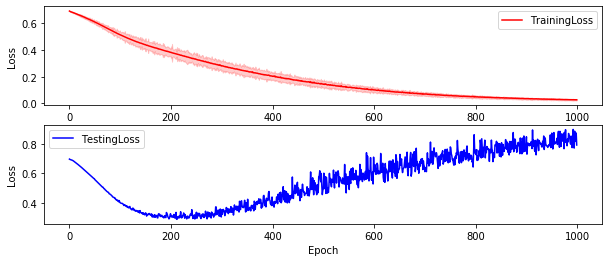

In [17]:
import matplotlib.pyplot as plt

#Plotting Loss

fig, axs = plt.subplots(2,1, figsize = (10,4))

trnLoss = np.asarray(loss_train_mean)
trnLossStd = np.asarray(loss_train_std)


axs[0].plot(loss_train_mean, color = 'red', label = "TrainingLoss")
axs[0].fill_between(range(totalEpoch), trnLoss - trnLossStd, trnLoss + trnLossStd, 
                    color = 'red', alpha=0.2)


axs[1].plot(loss_test, color = 'blue', label = "TestingLoss")

axs[0].set(ylabel = 'Loss')
axs[1].set(xlabel = 'Epoch', ylabel = 'Loss')

axs[0].legend()
axs[1].legend()

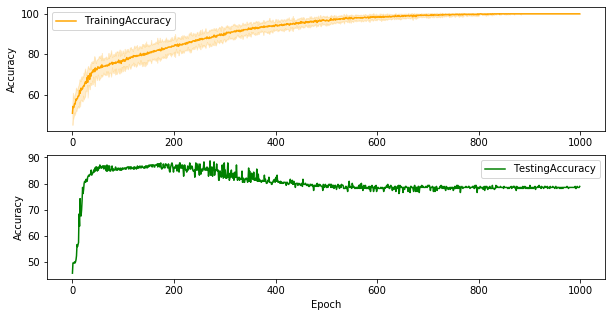

In [20]:
#Plotting Accuracy
fig, axs = plt.subplots(2,1, figsize = (10,5))



trnAcc = np.asarray(accuracy_train_mean)
trnAccStd = np.asarray(accuracy_train_std)



axs[0].plot(accuracy_train_mean, color = 'orange', label = "TrainingAccuracy")
axs[0].fill_between(range(totalEpoch), trnAcc - trnAccStd, trnAcc + trnAccStd, 
                    color = 'orange', alpha=0.2)



axs[1].plot(accuracy_test, color = 'green', label = "TestingAccuracy")


axs[0].set(ylabel = 'Accuracy')
axs[1].set(xlabel = 'Epoch', ylabel = 'Accuracy')

axs[0].legend()
axs[1].legend()

In [8]:
print("  Dataset   |     Loss     |    Accuracy")

print("  Training  | %.10f | %.10f" % (loss_train_mean[-1], accuracy_train_mean[-1]))
print("  Testing   | %.10f | %.10f" % (loss_test[-1], accuracy_test[-1]))

  Dataset   |     Loss     |    Accuracy
  Training  | 0.0272319251 | 100.0000000000
  Testing   | 0.7944175217 | 78.9062500000


In [ ]:
# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------
from tqdm import tqdm


loss_train_mean =[]
loss_train_std = []
accuracy_train_mean = []
accuracy_train_std = []

accuracy_test = []
loss_test = []


totalEpoch = 500
loop = tqdm(total = totalEpoch, position = 0, leave = False)

for e in range(totalEpoch):
    loop.set_description("Processing".format(e))
    loop.update(1)
    result_train    = train()
    result_test     = test()

    loss_train_mean.append(result_train['loss_train_mean'])
    accuracy_train_mean.append(result_train['accuracy_train_mean'])
    
    loss_train_std.append(result_train['loss_train_std'])
    accuracy_train_std.append(result_train['accuracy_train_std'])
    
    loss_test.append(result_test['loss_test'])
    accuracy_test.append(result_test['accuracy_test'])
    
    print("[epoch %5d] loss: (trn) %.10f, (test) %.10f, accuracy: (trn) %.10f, (test) %.10f" 
         % (e, loss_train_mean[e], loss_test[e], accuracy_train_mean[e], accuracy_test[e]))



In [ ]:
import matplotlib.pyplot as plt

#Plotting Loss

fig, axs = plt.subplots(2,1, figsize = (10,4))

trnLoss = np.asarray(loss_train_mean)
trnLossStd = np.asarray(loss_train_std)


axs[0].plot(loss_train_mean, color = 'red', label = "TrainingLoss")
axs[0].fill_between(range(totalEpoch), trnLoss - trnLossStd, trnLoss + trnLossStd, 
                    color = 'red', alpha=0.2)


axs[1].plot(loss_test, color = 'blue', label = "TestingLoss")

axs[0].set(ylabel = 'Loss')
axs[1].set(xlabel = 'Epoch', ylabel = 'Loss')

axs[0].legend()
axs[1].legend()

In [ ]:
#Plotting Accuracy
fig, axs = plt.subplots(2,1, figsize = (10,5))



trnAcc = np.asarray(accuracy_train_mean)
trnAccStd = np.asarray(accuracy_train_std)



axs[0].plot(accuracy_train_mean, color = 'orange', label = "TrainingAccuracy")
axs[0].fill_between(range(totalEpoch), trnAcc - trnAccStd, trnAcc + trnAccStd, 
                    color = 'orange', alpha=0.2)



axs[1].plot(accuracy_test, color = 'green', label = "TestingAccuracy")


axs[0].set(ylabel = 'Accuracy')
axs[1].set(xlabel = 'Epoch', ylabel = 'Accuracy')

axs[0].legend()
axs[1].legend()

In [ ]:
print("  Dataset   |     Loss     |    Accuracy")

print("  Training  | %.10f | %.10f" % (loss_train_mean[-1], accuracy_train_mean[-1]))
print("  Testing   | %.10f | %.10f" % (loss_test[-1], accuracy_test[-1]))